# Notebook structure:
* Pie-chart visualization
* Statistical fields visualization
* Preprocessing development
* Bar-chart n-grams visualization
* Word-clouds visualizations
* Preprocessing with `Pandarallel` using `clean` function
* Tokenization time test (`razdel` VS `TreeBankWord`)

**Dataset:** Top 100 films + low-rating films

**Dataset shape:**  $60058∗2$
 
**Reviews:** raw reviews with no preprocessing

# [Kaggle_instruction](https://www.kaggle.com/code/harshsingh2209/complete-guide-to-eda-on-text-data)

In [2]:
%cd ../..

from typing import List, Callable

import numpy as np
import pandas as pd
from pandarallel import pandarallel
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re
import tqdm
import dill

from sklearn.model_selection import train_test_split
from nltk.tokenize import TreebankWordTokenizer, TweetTokenizer, sent_tokenize
import razdel
from nltk.corpus import stopwords
import nltk
from sklearn.utils import resample
from gensim.models import Word2Vec

from pprint import pprint

from pymystem3 import Mystem
import pymorphy2

np.set_printoptions(threshold=np.inf)

In [3]:
from datasets.getters import load_reviews_Review_Label

data = load_reviews_Review_Label()
data = data.drop_duplicates(subset=['review'])
data

,review,label
0,«Зеленую милю» я смотрела два раза: 10 лет наз...,NEUTRAL
1,Период конца девяностых годов-начало двухтысяч...,POSITIVE
2,"Очень сложно писать рецензию на этот фильм, та...",POSITIVE
3,Любимая многими миллионами ценителями киноиску...,POSITIVE
4,В нашем мире существует много разных фильмов. ...,POSITIVE
...,...,...
65415,"За исключением легендарных '<b>Челюстей</b>', ...",NEUTRAL
65416,Действие фильма происходит на космическом кора...,NEGATIVE
65417,Стоило поверить низким оценкам и не смотреть э...,NEGATIVE
65418,"Так уж повелось, что каждый фильм из жанра фан...",NEGATIVE


In [4]:
data.label.value_counts()

POSITIVE    47847
NEUTRAL      6744
NEGATIVE     5467
Name: label, dtype: int64

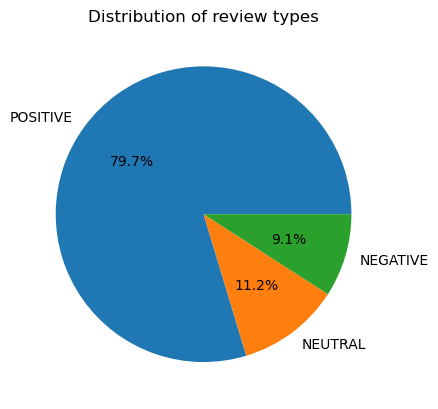

In [5]:
plt.pie(data.label.value_counts(), labels=data.label.value_counts().index, autopct='%1.1f%%')
plt.title('Distribution of review types')
plt.show()

## Statistical fields visualization

In [603]:
texts = data.review
texts

0        «Зеленую милю» я смотрела два раза: 10 лет наз...
1        Период конца девяностых годов-начало двухтысяч...
2        Очень сложно писать рецензию на этот фильм, та...
3        Любимая многими миллионами ценителями киноиску...
4        В нашем мире существует много разных фильмов. ...
                               ...                        
56583    3 мая – это не только день российской премьеры...
56584    Я люблю фильмы Уэса Андерсона. Они крутые. Но ...
56585    Посмотрел все работы Уэса Андерсона, - понрави...
56586    Знаменитый своей любовью к симметрии в каждом ...
56587    Уэс Андерсон объединился со свой обычной “кома...
Name: review, Length: 54951, dtype: object

In [604]:
data['sym_count'] = texts.str.len()
data

,review,label,sym_count
0,«Зеленую милю» я смотрела два раза: 10 лет наз...,NEUTRAL,2495
1,Период конца девяностых годов-начало двухтысяч...,POSITIVE,2686
2,"Очень сложно писать рецензию на этот фильм, та...",POSITIVE,2194
3,Любимая многими миллионами ценителями киноиску...,POSITIVE,1601
4,В нашем мире существует много разных фильмов. ...,POSITIVE,2576
...,...,...,...
56583,3 мая – это не только день российской премьеры...,POSITIVE,4692
56584,Я люблю фильмы Уэса Андерсона. Они крутые. Но ...,POSITIVE,2047
56585,"Посмотрел все работы Уэса Андерсона, - понрави...",NEUTRAL,1784
56586,Знаменитый своей любовью к симметрии в каждом ...,POSITIVE,3595


In [605]:
data.describe()

,sym_count
count,54951.000000
mean,2437.185966
std,1452.541286
min,62.000000
25%,1381.000000
50%,2080.000000
75%,3146.000000
max,21075.000000


In [606]:
data['token_count'] = texts.apply(lambda txt: len(txt.split()))
data

,review,label,sym_count,token_count
0,«Зеленую милю» я смотрела два раза: 10 лет наз...,NEUTRAL,2495,375
1,Период конца девяностых годов-начало двухтысяч...,POSITIVE,2686,393
2,"Очень сложно писать рецензию на этот фильм, та...",POSITIVE,2194,330
3,Любимая многими миллионами ценителями киноиску...,POSITIVE,1601,208
4,В нашем мире существует много разных фильмов. ...,POSITIVE,2576,393
...,...,...,...,...
56583,3 мая – это не только день российской премьеры...,POSITIVE,4692,692
56584,Я люблю фильмы Уэса Андерсона. Они крутые. Но ...,POSITIVE,2047,334
56585,"Посмотрел все работы Уэса Андерсона, - понрави...",NEUTRAL,1784,257
56586,Знаменитый своей любовью к симметрии в каждом ...,POSITIVE,3595,496


In [607]:
data['sent_count'] = texts.apply(lambda txt: len(sent_tokenize(txt)))
data

,review,label,sym_count,token_count,sent_count
0,«Зеленую милю» я смотрела два раза: 10 лет наз...,NEUTRAL,2495,375,26
1,Период конца девяностых годов-начало двухтысяч...,POSITIVE,2686,393,16
2,"Очень сложно писать рецензию на этот фильм, та...",POSITIVE,2194,330,26
3,Любимая многими миллионами ценителями киноиску...,POSITIVE,1601,208,10
4,В нашем мире существует много разных фильмов. ...,POSITIVE,2576,393,34
...,...,...,...,...,...
56583,3 мая – это не только день российской премьеры...,POSITIVE,4692,692,65
56584,Я люблю фильмы Уэса Андерсона. Они крутые. Но ...,POSITIVE,2047,334,33
56585,"Посмотрел все работы Уэса Андерсона, - понрави...",NEUTRAL,1784,257,14
56586,Знаменитый своей любовью к симметрии в каждом ...,POSITIVE,3595,496,20


In [608]:
data['mean_token_length'] = texts.map(lambda txt: np.mean([len(word) for word in txt.split()]))
data

,review,label,sym_count,token_count,sent_count,mean_token_length
0,«Зеленую милю» я смотрела два раза: 10 лет наз...,NEUTRAL,2495,375,26,5.573333
1,Период конца девяностых годов-начало двухтысяч...,POSITIVE,2686,393,16,5.730280
2,"Очень сложно писать рецензию на этот фильм, та...",POSITIVE,2194,330,26,5.575758
3,Любимая многими миллионами ценителями киноиску...,POSITIVE,1601,208,10,6.625000
4,В нашем мире существует много разных фильмов. ...,POSITIVE,2576,393,34,5.534351
...,...,...,...,...,...,...
56583,3 мая – это не только день российской премьеры...,POSITIVE,4692,692,65,5.687861
56584,Я люблю фильмы Уэса Андерсона. Они крутые. Но ...,POSITIVE,2047,334,33,5.056886
56585,"Посмотрел все работы Уэса Андерсона, - понрави...",NEUTRAL,1784,257,14,5.891051
56586,Знаменитый своей любовью к симметрии в каждом ...,POSITIVE,3595,496,20,6.189516


In [609]:
data['mean_sent_length'] = texts.map(lambda txt: np.mean([len(sent.split()) for sent in sent_tokenize(txt)]))
data

,review,label,sym_count,token_count,sent_count,mean_token_length,mean_sent_length
0,«Зеленую милю» я смотрела два раза: 10 лет наз...,NEUTRAL,2495,375,26,5.573333,14.423077
1,Период конца девяностых годов-начало двухтысяч...,POSITIVE,2686,393,16,5.730280,24.562500
2,"Очень сложно писать рецензию на этот фильм, та...",POSITIVE,2194,330,26,5.575758,12.692308
3,Любимая многими миллионами ценителями киноиску...,POSITIVE,1601,208,10,6.625000,20.800000
4,В нашем мире существует много разных фильмов. ...,POSITIVE,2576,393,34,5.534351,11.558824
...,...,...,...,...,...,...,...
56583,3 мая – это не только день российской премьеры...,POSITIVE,4692,692,65,5.687861,10.646154
56584,Я люблю фильмы Уэса Андерсона. Они крутые. Но ...,POSITIVE,2047,334,33,5.056886,10.121212
56585,"Посмотрел все работы Уэса Андерсона, - понрави...",NEUTRAL,1784,257,14,5.891051,18.357143
56586,Знаменитый своей любовью к симметрии в каждом ...,POSITIVE,3595,496,20,6.189516,24.800000


([<matplotlib.patches.Wedge at 0x1cb45edd460>,
 [Text(-0.4368626645752141, 1.009530094796705, 'POSITIVE'),
  Text(-0.172077952232839, -1.086457168210212, 'NEUTRAL'),
  Text(0.928760704807937, -0.5894094953465411, 'NEGATIVE')],
 [Text(-0.2382887261319349, 0.5506527789800209, '63.0%'),
  Text(-0.09386070121791217, -0.5926130008419338, '19.0%'),
  Text(0.5065967480770565, -0.3214960883708406, '18.0%')])

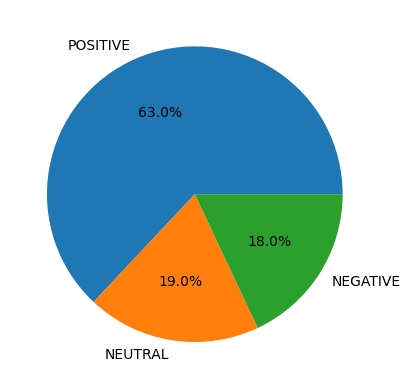

In [615]:
plt.pie(data.sort_values(by='sent_count', ascending=False)[:100].label.value_counts(), labels=data.label.value_counts().index, autopct='%1.1f%%')

([<matplotlib.patches.Wedge at 0x1c8aa88c8e0>,
 [Text(-0.9219097779409624, 0.6000686305222473, 'POSITIVE'),
  Text(0.7429228299369227, -0.8112124683204237, 'NEUTRAL'),
  Text(1.0651736339206368, -0.2745999446473092, 'NEGATIVE')],
 [Text(-0.5028598788768885, 0.327310162103044, '81.6%'),
  Text(0.4052306345110487, -0.44247952817477654, '10.3%'),
  Text(0.5810038003203473, -0.14978178798944136, '8.0%')])

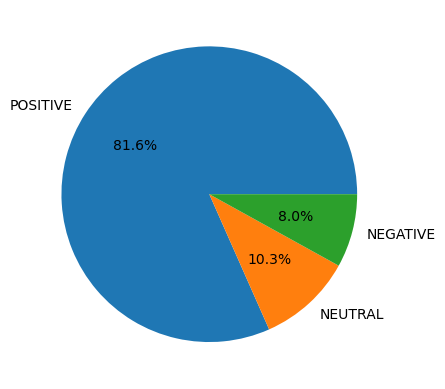

In [622]:
plt.pie(data.sort_values(by='sent_count', ascending=False)[5000:50000].label.value_counts(), labels=data.label.value_counts().index, autopct='%1.1f%%')

---

## Preprocessing

In [635]:
data = load_reviews_Review_Label()
data = data.drop_duplicates(subset=['review'])
data

,review,label
0,«Зеленую милю» я смотрела два раза: 10 лет наз...,NEUTRAL
1,Период конца девяностых годов-начало двухтысяч...,POSITIVE
2,"Очень сложно писать рецензию на этот фильм, та...",POSITIVE
3,Любимая многими миллионами ценителями киноиску...,POSITIVE
4,В нашем мире существует много разных фильмов. ...,POSITIVE
...,...,...
56583,3 мая – это не только день российской премьеры...,POSITIVE
56584,Я люблю фильмы Уэса Андерсона. Они крутые. Но ...,POSITIVE
56585,"Посмотрел все работы Уэса Андерсона, - понрави...",NEUTRAL
56586,Знаменитый своей любовью к симметрии в каждом ...,POSITIVE


In [636]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54951 entries, 0 to 56587
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   review  54951 non-null  object
 1   label   54951 non-null  object
dtypes: object(2)
memory usage: 1.3+ MB


In [72]:
stopwords.words('russian')

['и',
 'в',
 'во',
 'не',
 'что',
 'он',
 'на',
 'я',
 'с',
 'со',
 'как',
 'а',
 'то',
 'все',
 'она',
 'так',
 'его',
 'но',
 'да',
 'ты',
 'к',
 'у',
 'же',
 'вы',
 'за',
 'бы',
 'по',
 'только',
 'ее',
 'мне',
 'было',
 'вот',
 'от',
 'меня',
 'еще',
 'нет',
 'о',
 'из',
 'ему',
 'теперь',
 'когда',
 'даже',
 'ну',
 'вдруг',
 'ли',
 'если',
 'уже',
 'или',
 'ни',
 'быть',
 'был',
 'него',
 'до',
 'вас',
 'нибудь',
 'опять',
 'уж',
 'вам',
 'ведь',
 'там',
 'потом',
 'себя',
 'ничего',
 'ей',
 'может',
 'они',
 'тут',
 'где',
 'есть',
 'надо',
 'ней',
 'для',
 'мы',
 'тебя',
 'их',
 'чем',
 'была',
 'сам',
 'чтоб',
 'без',
 'будто',
 'чего',
 'раз',
 'тоже',
 'себе',
 'под',
 'будет',
 'ж',
 'тогда',
 'кто',
 'этот',
 'того',
 'потому',
 'этого',
 'какой',
 'совсем',
 'ним',
 'здесь',
 'этом',
 'один',
 'почти',
 'мой',
 'тем',
 'чтобы',
 'нее',
 'сейчас',
 'были',
 'куда',
 'зачем',
 'всех',
 'никогда',
 'можно',
 'при',
 'наконец',
 'два',
 'об',
 'другой',
 'хоть',
 'после',
 'на

In [368]:
texts = data.review
texts

0        «Зеленую милю» я смотрела два раза: 10 лет наз...
1        Период конца девяностых годов-начало двухтысяч...
2        Очень сложно писать рецензию на этот фильм, та...
3        Любимая многими миллионами ценителями киноиску...
4        В нашем мире существует много разных фильмов. ...
                               ...                        
56583    3 мая – это не только день российской премьеры...
56584    Я люблю фильмы Уэса Андерсона. Они крутые. Но ...
56585    Посмотрел все работы Уэса Андерсона, - понрави...
56586    Знаменитый своей любовью к симметрии в каждом ...
56587    Уэс Андерсон объединился со свой обычной “кома...
Name: review, Length: 54951, dtype: object

In [75]:
txt = '«Зеленую милю» я смотрела два раза: 10 лет назад и сейчас. \r\n\r\nПервый раз у меня было примерно такое впечатление, о котором говорят большинство зрителей. Я плакала над глубокой и грустной историей, которая надолго оставила след в душе, тем более, что я была подростком.  \r\n\r\nНесколько лет назад прочитала оригинальный роман Кинга и периодически думала, насколько хороша и точна экранизация (хотя сам фильм я уже успела подзабыть, некоторые моменты еще были живы в памяти). \r\n\r\nСейчас же я решила освежить впечатления и пощекотать эмоции, но это парадоксальным образом не сработало. После взросления и прочтения книги фильм Дарабонта показался мне плоским, как блин, и даже немного не раскрывающим темы, на которые замахивается. Это довольно странно, учитывая, что фильм идет три часа, при этом являясь экранизацией не такой уж и большой книги.\r\n\r\nТемы расизма, злоупотребления властью, жизни и смерти — все это отдается на откуп зрительскому восприятию. Особенно нелепа вся эта линия с травлей Перси: за весь  фильм толком непонятно, за что сослуживцы так его ненавидят. За то, что хочет убить милое, но потенциально вредное животное? За то, что работает по блату (во времена Депрессии, ага)? Если честно, эта сюжетная линия выглядит как разборки старшеклассников, а не как работа тюремного блока. \r\n\r\nИ кстати, ради большей слезовыжималки сценаристы умолчали преступление Делакруа, выставив его чуть ли не положительным персонажем. Мне и в романе-то не нравилось постоянные заигрывания тюремщиков с ним, но здесь это выкрутили да абсурда.\r\n\r\nВина ли это сценариста и режиссера? Да нет, в общем. Просто «Зеленую милю» невозможно экранизировать. Помимо самих событий там много рефлексии, печальных воспоминаний, внутренних рассуждений героев о морали и общественных нормах. Это не такой большой, но плотный роман, под завязку забитый вещами, которые нельзя перевести на язык кино. \r\n\r\nИ все же я считаю, что Дарабонт сделал все, что в его силах, и фильм получился настолько хорошим, насколько это вообще было возможно. И кстати, кое-что получилось идеально: атмосфера фильма идеально передает общий тон книги. Про актерскую игру и речи нет. Особенно запал в душу Майкл Кларк Дункан. Он проделал фантастическую работу даже по меркам профессиональных актеров, а ведь у него вроде как не было полноценного образования.\r\n\r\nХотя сейчас я уже не испытываю от фильма тех же чувств, что и раньше, считаю огромной несправедливостью, что он не взял ни одного «Оскара». Очень жаль: у картины были все шансы.'

In [76]:
pattern = re.compile('[\w]+')
pattern.findall(txt)

['Зеленую',
 'милю',
 'я',
 'смотрела',
 'два',
 'раза',
 '10',
 'лет',
 'назад',
 'и',
 'сейчас',
 'Первый',
 'раз',
 'у',
 'меня',
 'было',
 'примерно',
 'такое',
 'впечатление',
 'о',
 'котором',
 'говорят',
 'большинство',
 'зрителей',
 'Я',
 'плакала',
 'над',
 'глубокой',
 'и',
 'грустной',
 'историей',
 'которая',
 'надолго',
 'оставила',
 'след',
 'в',
 'душе',
 'тем',
 'более',
 'что',
 'я',
 'была',
 'подростком',
 'Несколько',
 'лет',
 'назад',
 'прочитала',
 'оригинальный',
 'роман',
 'Кинга',
 'и',
 'периодически',
 'думала',
 'насколько',
 'хороша',
 'и',
 'точна',
 'экранизация',
 'хотя',
 'сам',
 'фильм',
 'я',
 'уже',
 'успела',
 'подзабыть',
 'некоторые',
 'моменты',
 'еще',
 'были',
 'живы',
 'в',
 'памяти',
 'Сейчас',
 'же',
 'я',
 'решила',
 'освежить',
 'впечатления',
 'и',
 'пощекотать',
 'эмоции',
 'но',
 'это',
 'парадоксальным',
 'образом',
 'не',
 'сработало',
 'После',
 'взросления',
 'и',
 'прочтения',
 'книги',
 'фильм',
 'Дарабонта',
 'показался',
 'мне',

In [370]:
def clean(review):    
    review = review.lower()
    review = TreebankWordTokenizer().tokenize(review)
    sw = stopwords.words('russian')
    review = " ".join([word for word in review if word not in sw])
    
    return review

In [371]:
%%time

data['review'] = data['review'].apply(clean)
data

Wall time: 1min 26s


,review,label
0,«зеленую милю» смотрела раза : 10 лет назад се...,NEUTRAL
1,период конца девяностых годов-начало двухтысяч...,POSITIVE
2,"очень сложно писать рецензию фильм , это прост...",POSITIVE
3,любимая многими миллионами ценителями киноиску...,POSITIVE
4,нашем мире существует разных фильмов. одни цеп...,POSITIVE
...,...,...
56583,3 мая – это день российской премьеры «войны бе...,POSITIVE
56584,люблю фильмы уэса андерсона. крутые. одна проб...,POSITIVE
56585,"посмотрел работы уэса андерсона , - понравилис...",NEUTRAL
56586,знаменитый своей любовью симметрии каждом кадр...,POSITIVE


#### Using broad vocabulary of stopwords.

In [637]:
data = load_reviews_Review_Label()
data = data.drop_duplicates(subset=['review'])
data

,review,label
0,«Зеленую милю» я смотрела два раза: 10 лет наз...,NEUTRAL
1,Период конца девяностых годов-начало двухтысяч...,POSITIVE
2,"Очень сложно писать рецензию на этот фильм, та...",POSITIVE
3,Любимая многими миллионами ценителями киноиску...,POSITIVE
4,В нашем мире существует много разных фильмов. ...,POSITIVE
...,...,...
56583,3 мая – это не только день российской премьеры...,POSITIVE
56584,Я люблю фильмы Уэса Андерсона. Они крутые. Но ...,POSITIVE
56585,"Посмотрел все работы Уэса Андерсона, - понрави...",NEUTRAL
56586,Знаменитый своей любовью к симметрии в каждом ...,POSITIVE


In [640]:
with open('stop-ru.txt', 'rt', encoding='UTF-8') as f:
    stopwords = f.read().split('\n')

def clean(review):    
    review = review.lower()
    review = TreebankWordTokenizer().tokenize(review)
    # sw = stopwords.words('russian')
    review = " ".join([word for word in review if word not in stopwords])
    
    return review

In [641]:
data['review'] = data['review'].apply(clean)
data

,review,label
0,«зеленую милю» смотрела раза : 10 сейчас. впеч...,NEUTRAL
1,период конца девяностых годов-начало двухтысяч...,POSITIVE
2,"рецензию фильм , видеть. самых эмоциональных с...",POSITIVE
3,любимая многими миллионами ценителями киноиску...,POSITIVE
4,"мире разных фильмов. цепляют , хочется пересма...",POSITIVE
...,...,...
56583,3 мая – российской премьеры «войны бесконечнос...,POSITIVE
56584,люблю фильмы уэса андерсона. крутые. проблема....,POSITIVE
56585,"посмотрел уэса андерсона , - понравились ( кин...",NEUTRAL
56586,"знаменитый любовью симметрии каждом кадре , уэ...",POSITIVE


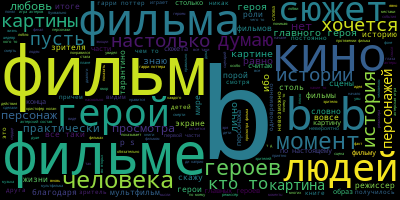

In [642]:
wc = WordCloud().generate(' '.join(data.review))
wc.to_image()

## Visualization

In [589]:
def get_n_most_frequent_ngrams(data, ngram_range: tuple = (1, 1), top_n: int = 10):
    print(f'{ngram_range=}')
    print('Building vocabulary...')
    cnt_vec = CountVectorizer(ngram_range=ngram_range)
    cnt_vec.fit(data)
    print('Vectorizing documents...')
    docs_embs = cnt_vec.transform(data)
    print(f'{docs_embs.shape=}')
    
    print('Preparing values...')    
    token_freqs = np.array(np.sum(docs_embs, axis=0))[0]
    max_idxs = np.argpartition(token_freqs, -top_n)[-top_n:]
    max_freqs = token_freqs[max_idxs]
    most_frequent_tokens = cnt_vec.get_feature_names_out()[max_idxs]

    concated = pd.DataFrame(np.concatenate((max_freqs.reshape(-1, 1), most_frequent_tokens.reshape(-1, 1)), axis=1), 
                            columns=['freqs', 'tokens'])
    
    concated.sort_values(by=['freqs'], inplace=True, ascending=False, ignore_index=True)
    
    print(end='\n')
        
    return concated
    

In [418]:
data

,review,label
0,«зеленую милю» смотрела раза : 10 лет назад се...,NEUTRAL
1,период конца девяностых годов-начало двухтысяч...,POSITIVE
2,"очень сложно писать рецензию фильм , это прост...",POSITIVE
3,любимая многими миллионами ценителями киноиску...,POSITIVE
4,нашем мире существует разных фильмов. одни цеп...,POSITIVE
...,...,...
56583,3 мая – это день российской премьеры «войны бе...,POSITIVE
56584,люблю фильмы уэса андерсона. крутые. одна проб...,POSITIVE
56585,"посмотрел работы уэса андерсона , - понравилис...",NEUTRAL
56586,знаменитый своей любовью симметрии каждом кадр...,POSITIVE


Building vocabulary...
Vectorizing documents...
docs_embs.shape=(54951, 358854)
Preparing values...


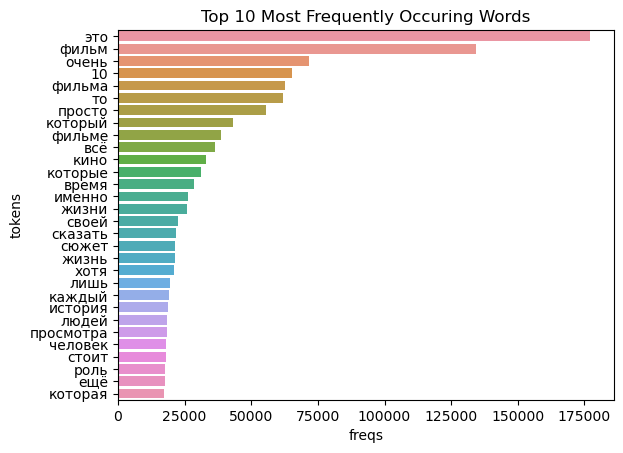

,freqs,tokens
0,177186,это
1,134262,фильм
2,71607,очень
3,65171,10
4,62792,фильма
5,61813,то
6,55569,просто
7,43294,который
8,38569,фильме
9,36586,всё


In [374]:
get_n_most_frequent_ngrams(data.review, top_n=30)

Building vocabulary...
Vectorizing documents...
docs_embs.shape=(54951, 12577691)
Preparing values...


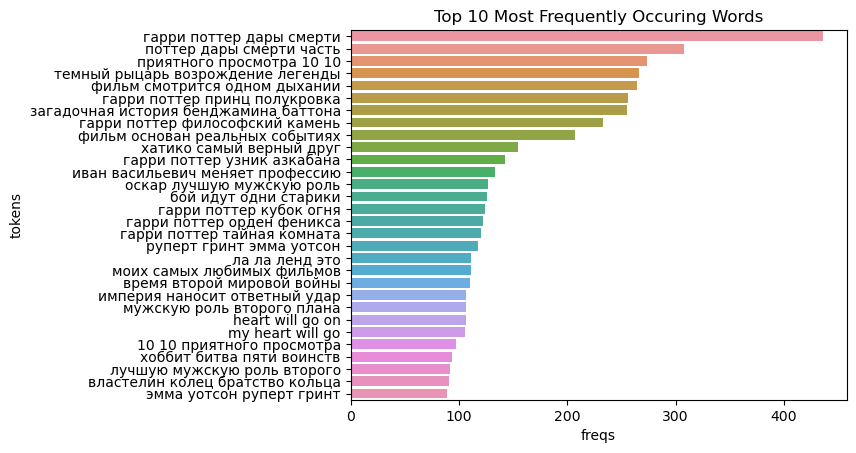

,freqs,tokens
0,436,гарри поттер дары смерти
1,308,поттер дары смерти часть
2,274,приятного просмотра 10 10
3,266,темный рыцарь возрождение легенды
4,264,фильм смотрится одном дыхании
5,256,гарри поттер принц полукровка
6,255,загадочная история бенджамина баттона
7,233,гарри поттер философский камень
8,207,фильм основан реальных событиях
9,155,хатико самый верный друг


In [376]:
get_n_most_frequent_ngrams(data.review, ngram_range=(4, 4), top_n=30)

In [592]:
def visualize_ngram_occurrences(corpus, ngram_range: tuple = (1, 1), top_n = 10):
    assert len(ngram_range) == 2, "Wrong length of ngram_range parameter. Expected 'ngram_range' == 2."
    
    fig, ax = plt.subplots(ngram_range[1] - ngram_range[0] + 1, 1, figsize=(3 + ngram_range[1] * 2.5, ngram_range[1] * (1.1 + (top_n-1) / 8)))

    if not isinstance(ax, np.ndarray):
         ax = np.array([ax])    
    
    for i, ngram in enumerate(range(ngram_range[0], ngram_range[1] + 1)):
        df = get_n_most_frequent_ngrams(corpus, ngram_range=(ngram, ngram), top_n=top_n)
        sns.barplot(x=df['freqs'], y=df['tokens'], ax=ax[i])
        ax[i].set_title(f'Top 10 Most Frequently Occuring {(ngram, ngram)} ngrams', weight='bold')
        ax[i].grid(color='gainsboro')
    
    plt.tight_layout()

ngram_range=(1, 1)
Building vocabulary...
Vectorizing documents...
docs_embs.shape=(54951, 358854)
Preparing values...

ngram_range=(2, 2)
Building vocabulary...
Vectorizing documents...
docs_embs.shape=(54951, 7208762)
Preparing values...

ngram_range=(3, 3)
Building vocabulary...
Vectorizing documents...
docs_embs.shape=(54951, 11670756)
Preparing values...

ngram_range=(4, 4)
Building vocabulary...
Vectorizing documents...
docs_embs.shape=(54951, 12577691)
Preparing values...

Wall time: 4min 37s


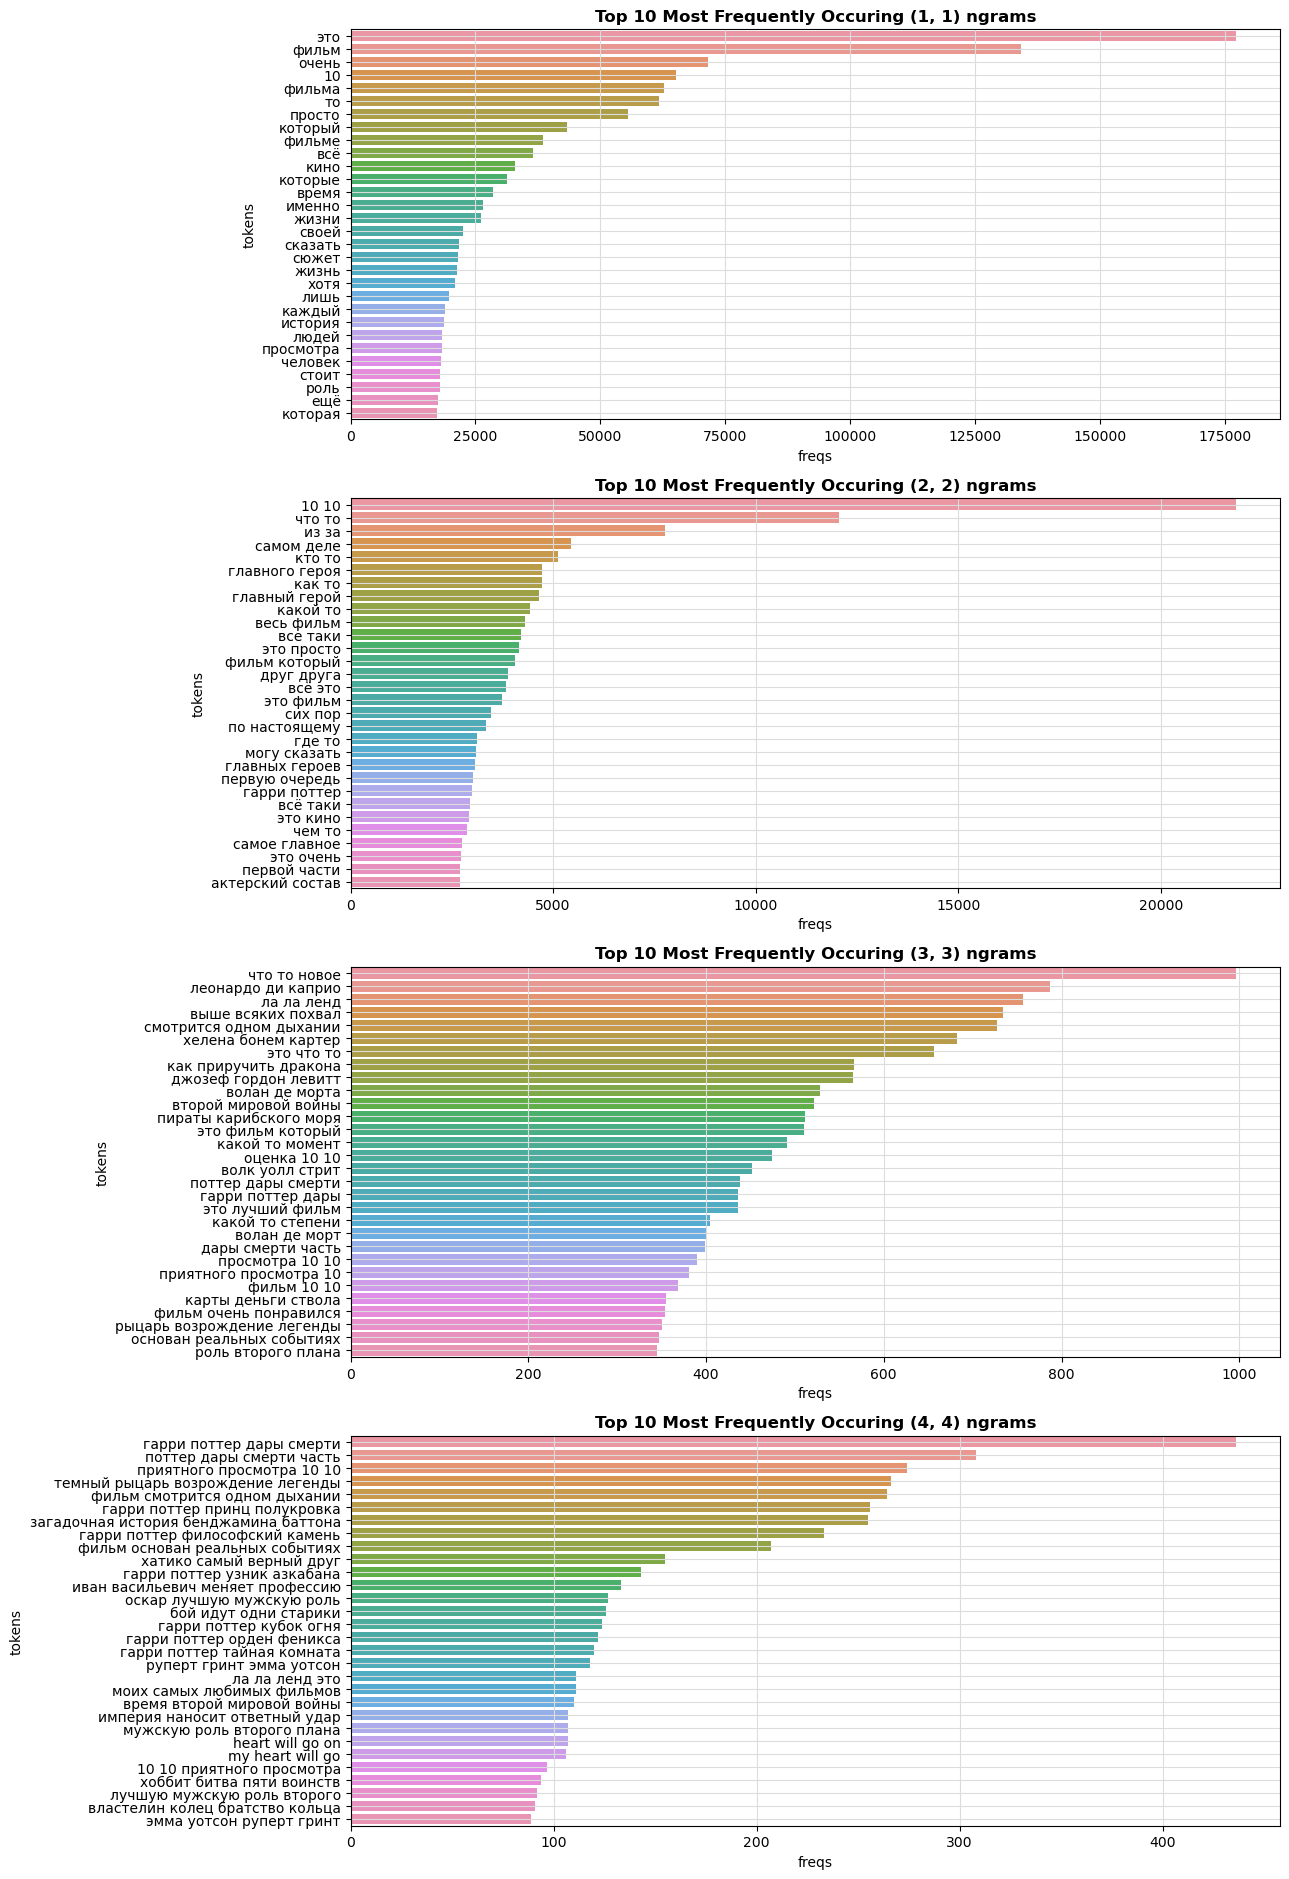

In [591]:
%%time

visualize_ngram_occurrences(data.review, top_n=30, ngram_range=(1, 4))

In [566]:
positive_data = data[data.label == 'POSITIVE']
neutral_data = data[data.label == 'NEUTRAL']
negative_data = data[data.label == 'NEGATIVE']

print(f'Initial {data.shape=}')

(positive_data.shape, neutral_data.shape, negative_data.shape)

Initial data.shape=(54951, 2)


((44533, 2), (5886, 2), (4532, 2))

ngram_range=(1, 1)
Building vocabulary...
Vectorizing documents...
docs_embs.shape=(44533, 316694)
Preparing values...

ngram_range=(2, 2)
Building vocabulary...
Vectorizing documents...
docs_embs.shape=(44533, 5917782)
Preparing values...

ngram_range=(3, 3)
Building vocabulary...
Vectorizing documents...
docs_embs.shape=(44533, 9446798)
Preparing values...

ngram_range=(4, 4)
Building vocabulary...
Vectorizing documents...
docs_embs.shape=(44533, 10165849)
Preparing values...

Wall time: 3min 48s


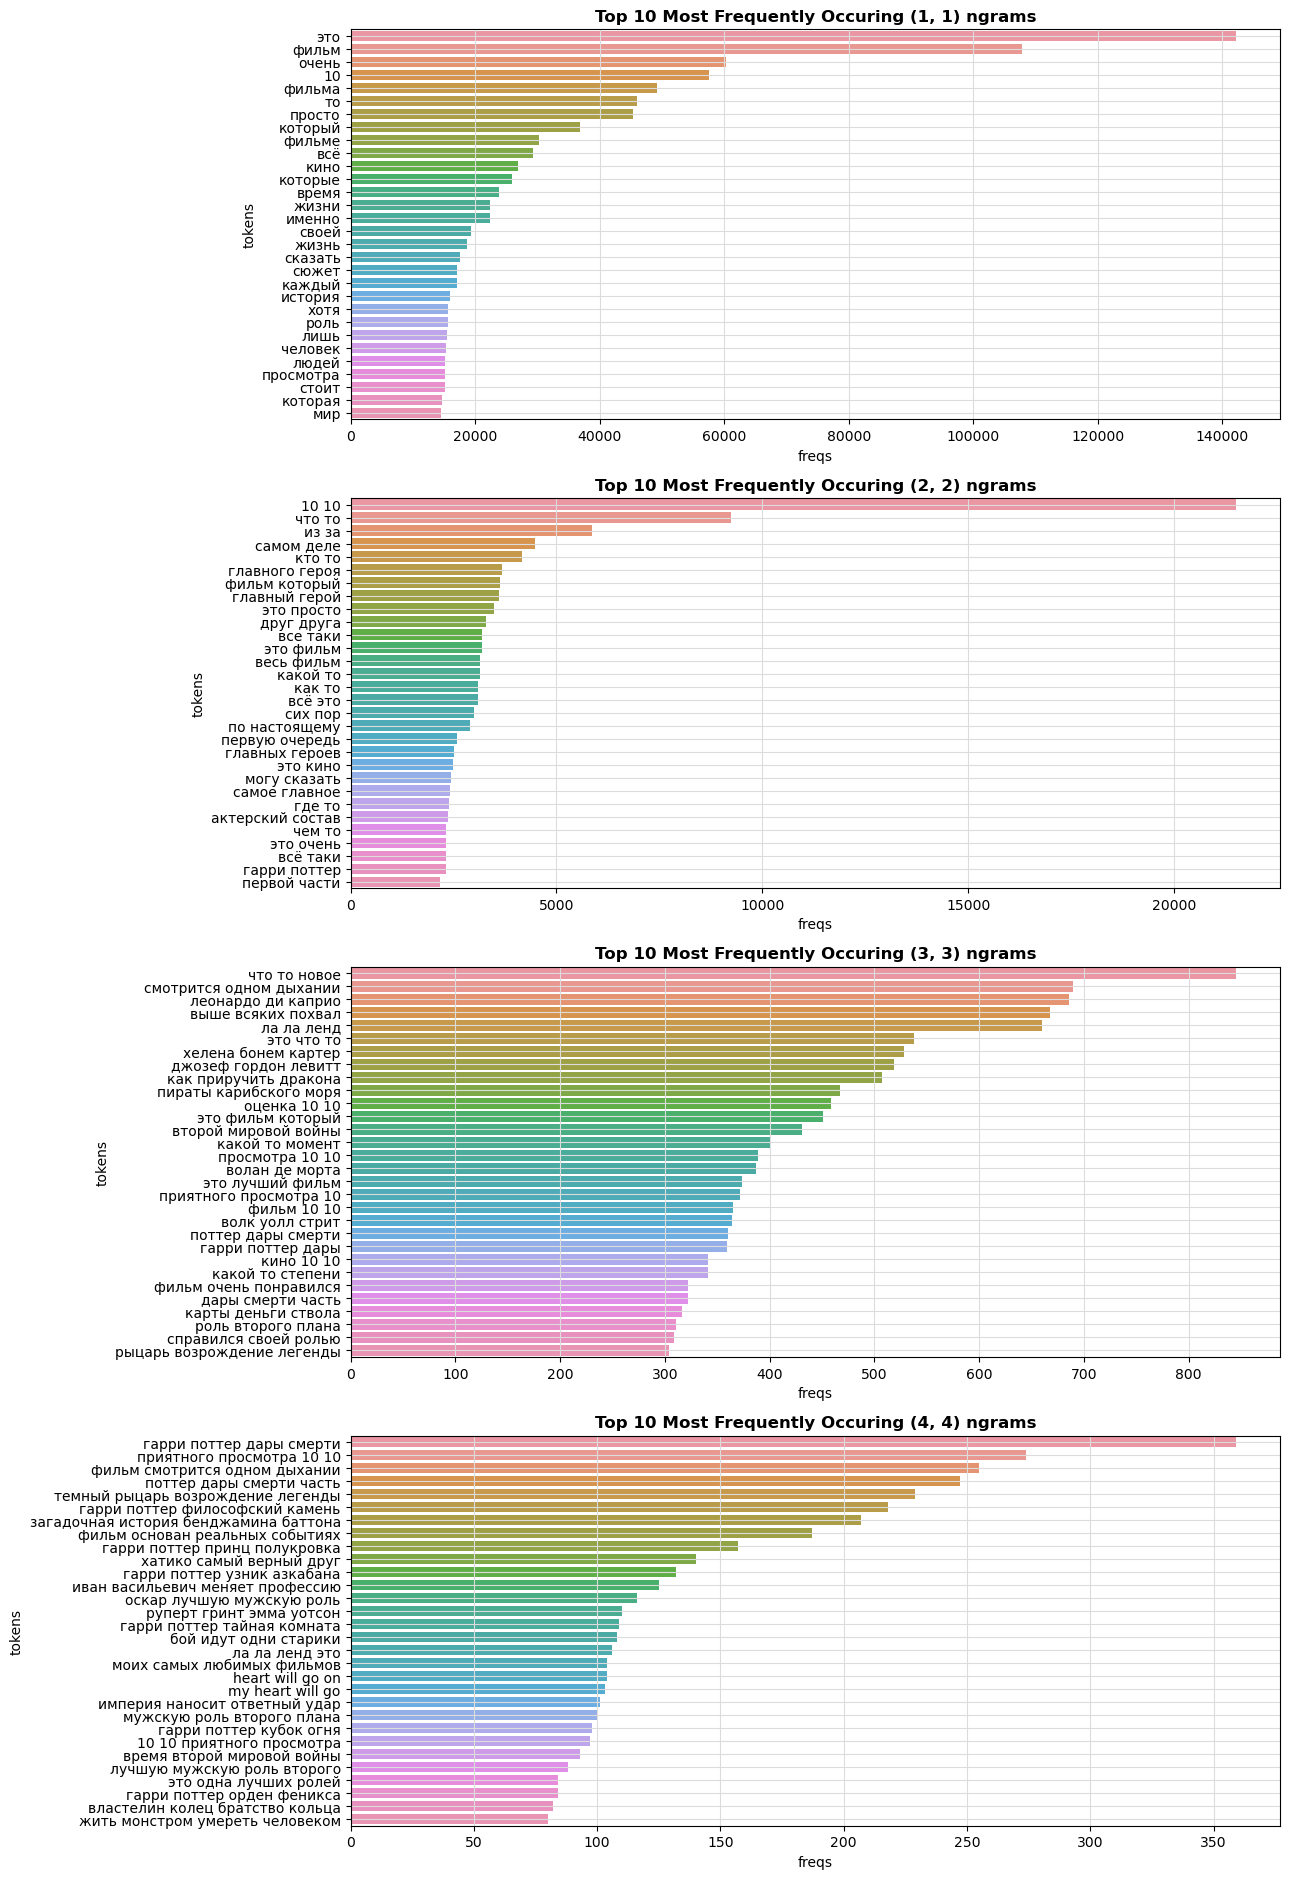

In [593]:
%%time

visualize_ngram_occurrences(positive_data.review, top_n=30, ngram_range=(1, 4))

ngram_range=(1, 1)
Building vocabulary...
Vectorizing documents...
docs_embs.shape=(5886, 136148)
Preparing values...

ngram_range=(2, 2)
Building vocabulary...
Vectorizing documents...
docs_embs.shape=(5886, 1039432)
Preparing values...

ngram_range=(3, 3)
Building vocabulary...
Vectorizing documents...
docs_embs.shape=(5886, 1303168)
Preparing values...

ngram_range=(4, 4)
Building vocabulary...
Vectorizing documents...
docs_embs.shape=(5886, 1328231)
Preparing values...

Wall time: 27.4 s


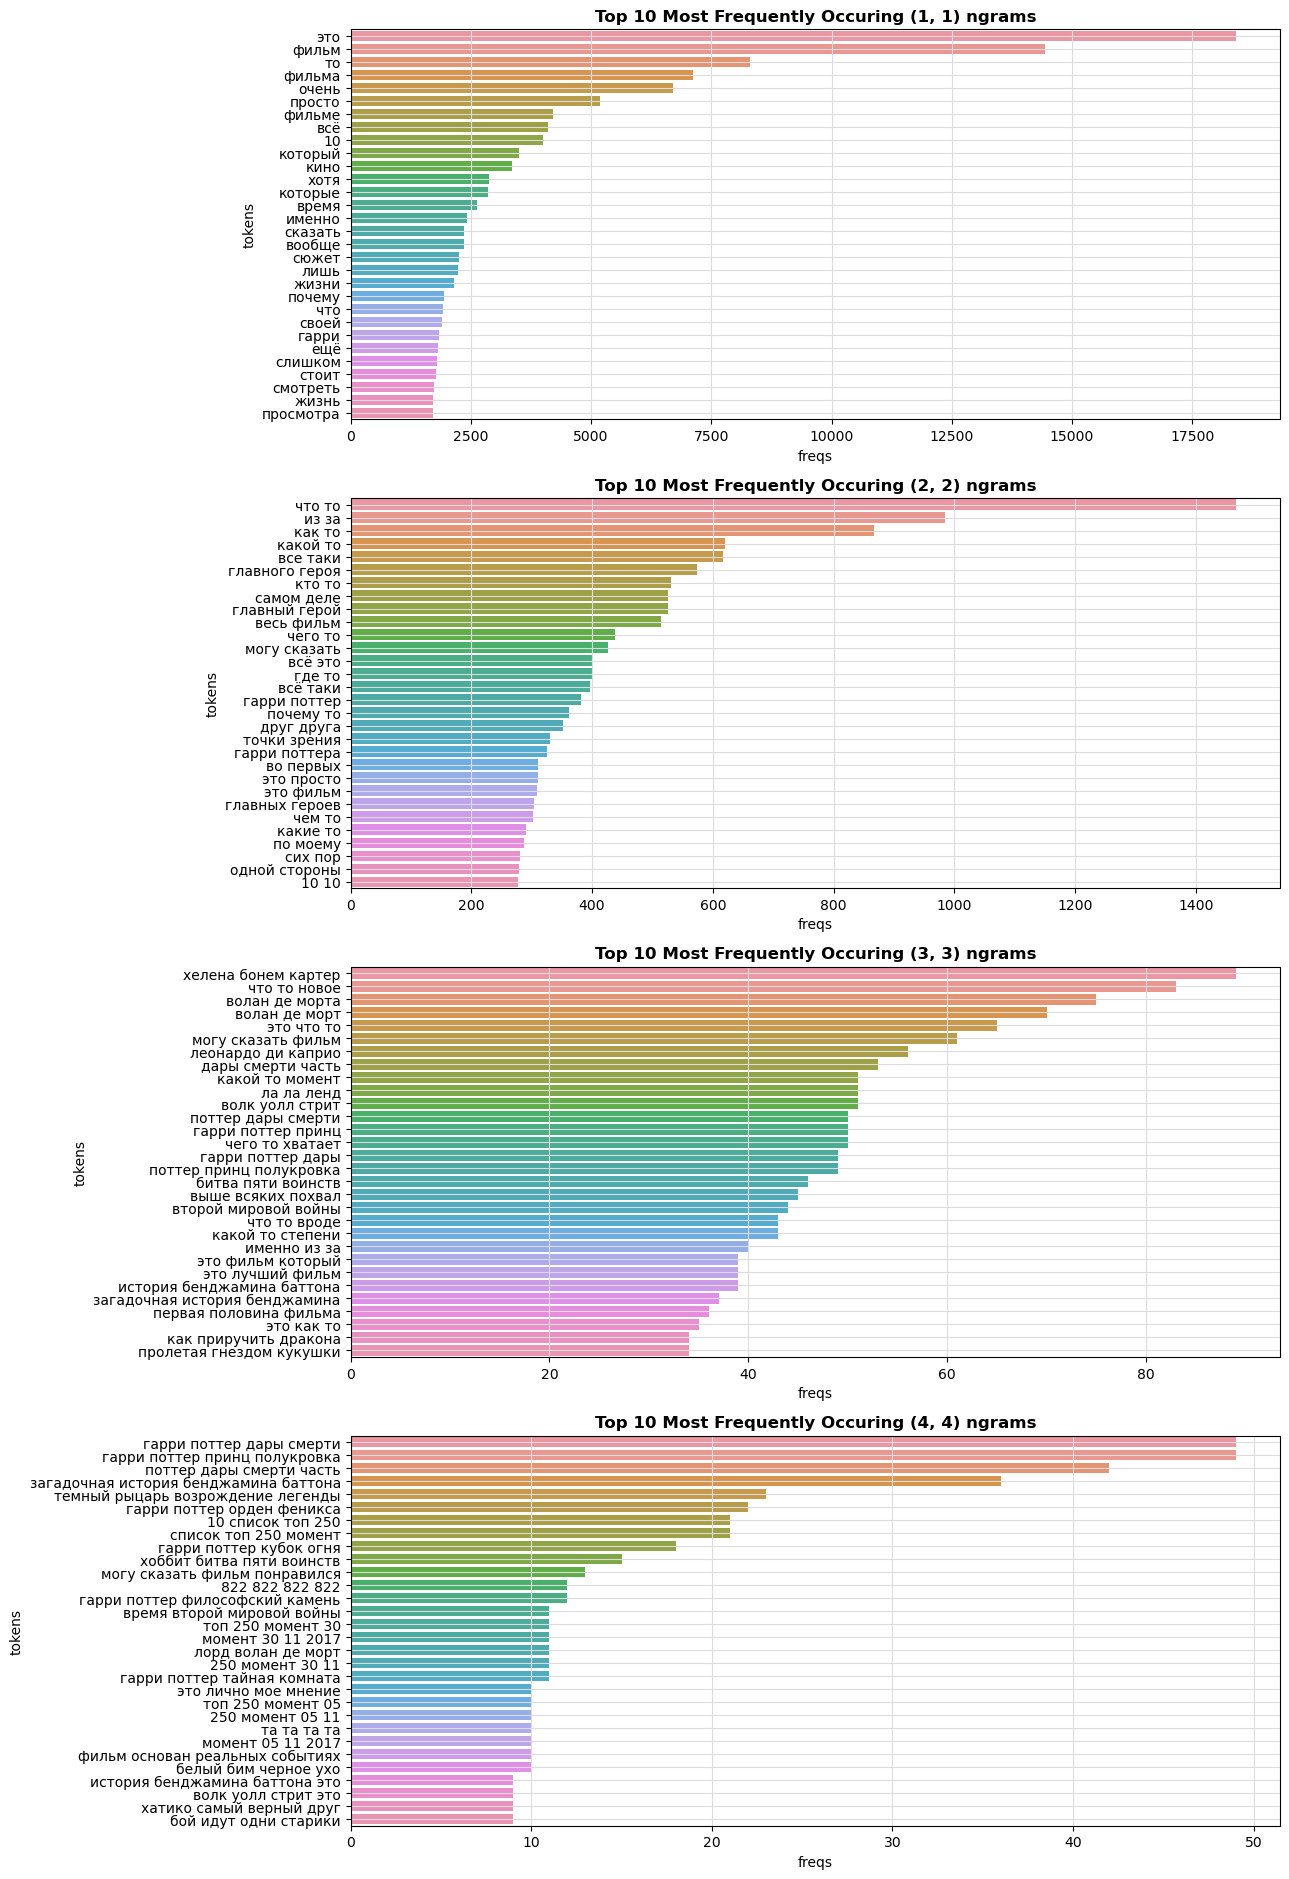

In [594]:
%%time

visualize_ngram_occurrences(neutral_data.review, top_n=30, ngram_range=(1, 4))

ngram_range=(1, 1)
Building vocabulary...
Vectorizing documents...
docs_embs.shape=(4532, 125539)
Preparing values...

ngram_range=(2, 2)
Building vocabulary...
Vectorizing documents...
docs_embs.shape=(4532, 890801)
Preparing values...

ngram_range=(3, 3)
Building vocabulary...
Vectorizing documents...
docs_embs.shape=(4532, 1100753)
Preparing values...

ngram_range=(4, 4)
Building vocabulary...
Vectorizing documents...
docs_embs.shape=(4532, 1119637)
Preparing values...

Wall time: 23.2 s


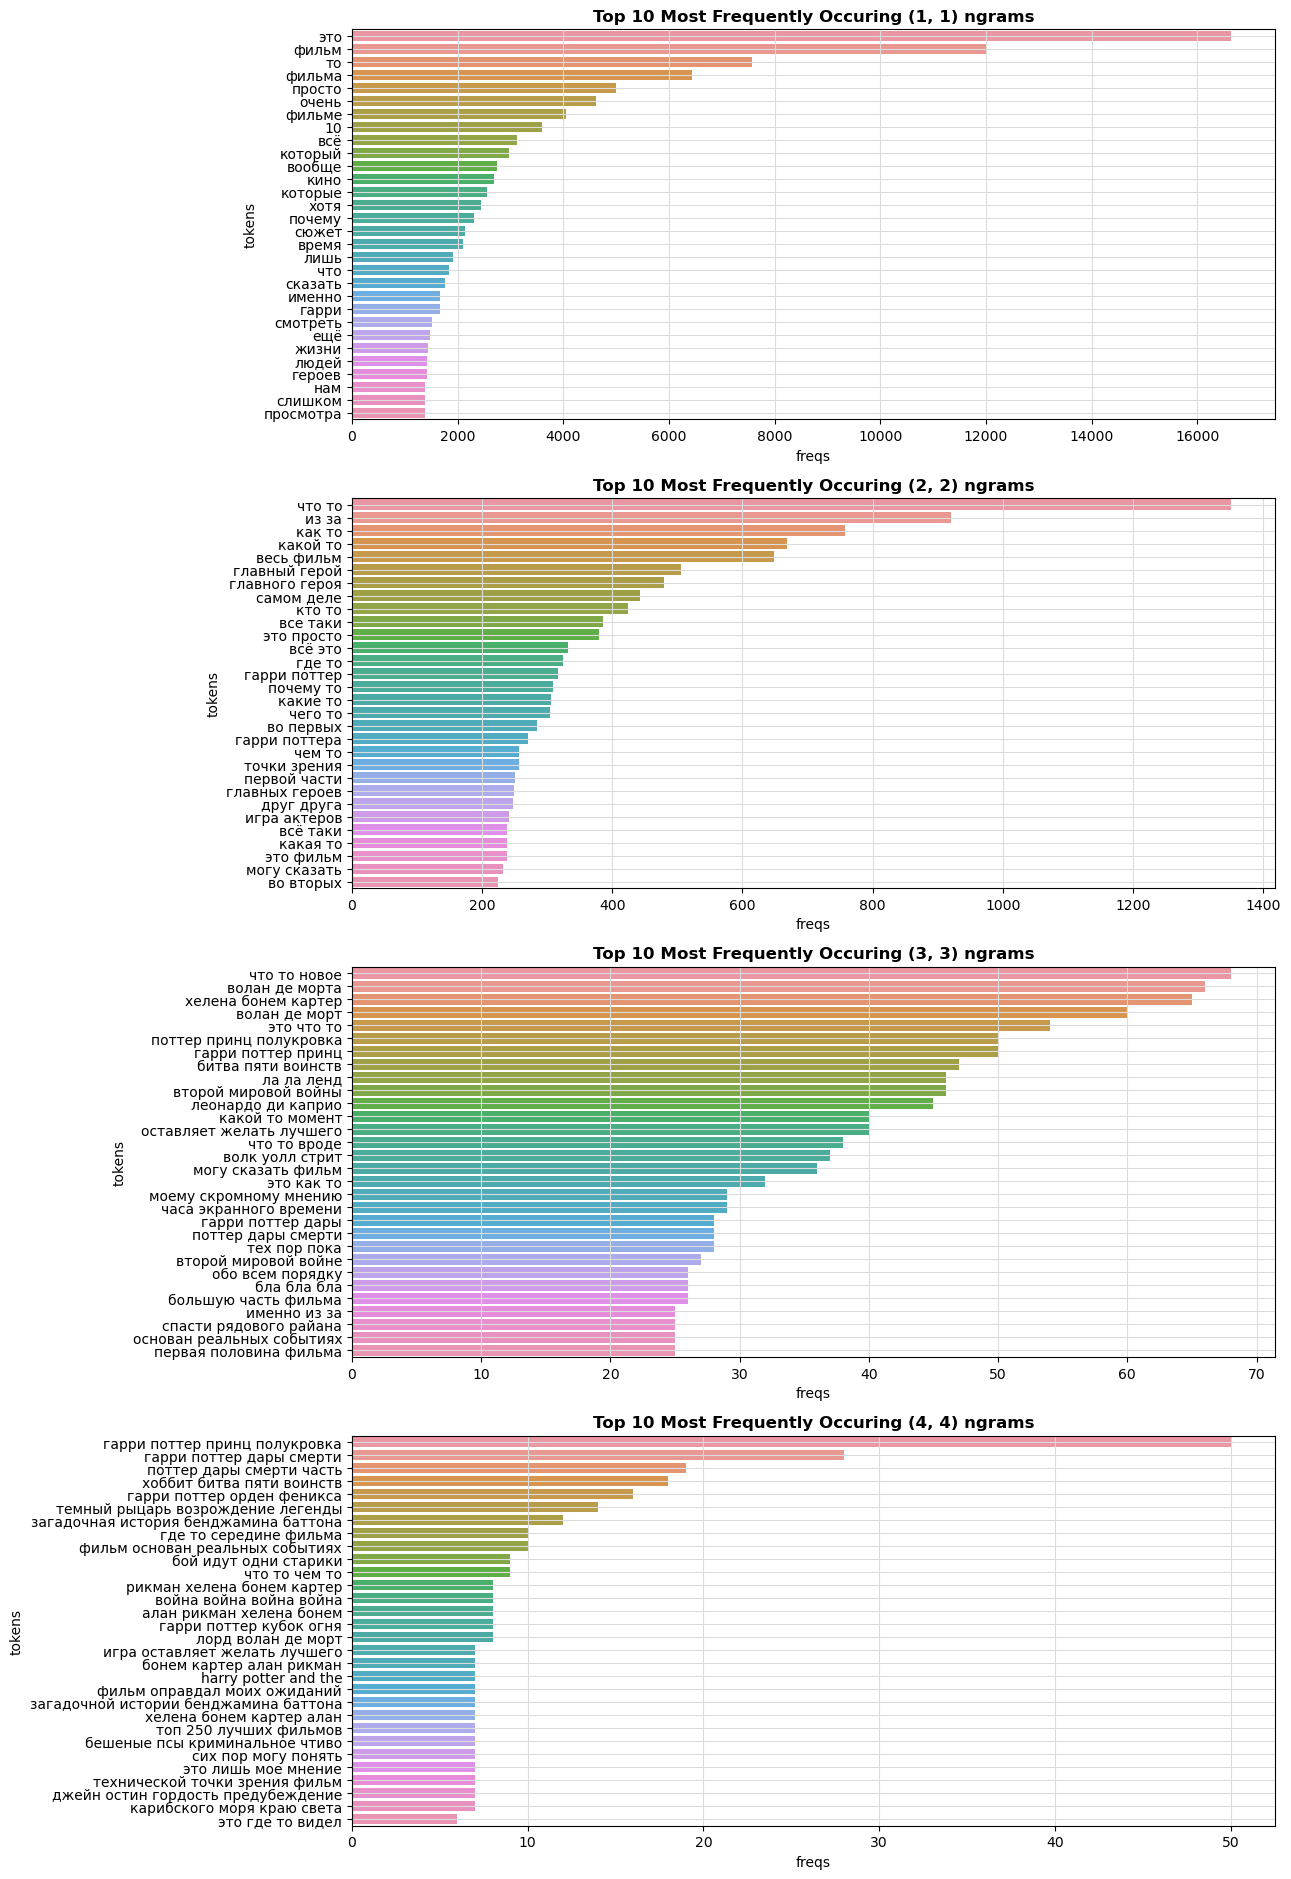

In [595]:
%%time

visualize_ngram_occurrences(negative_data.review, top_n=30, ngram_range=(1, 4))

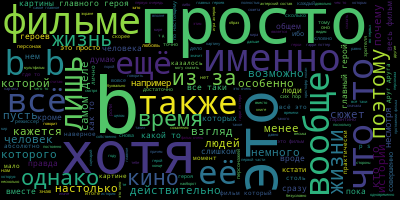

In [596]:
wc = WordCloud().generate(' '.join(data.review))
wc.to_image()

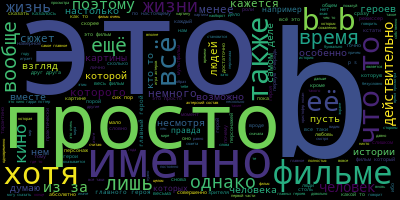

In [597]:
wc = WordCloud().generate(' '.join(positive_data.review))
wc.to_image()

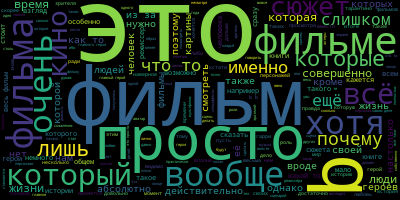

In [598]:
wc = WordCloud().generate(' '.join(negative_data.review))
wc.to_image()

---

# Full preprocessing

In [13]:
from datasets.getters import load_reviews_Review_Label

data = load_reviews_Review_Label()
data

,review,label
0,«Зеленую милю» я смотрела два раза: 10 лет наз...,NEUTRAL
1,Период конца девяностых годов-начало двухтысяч...,POSITIVE
2,"Очень сложно писать рецензию на этот фильм, та...",POSITIVE
3,Любимая многими миллионами ценителями киноиску...,POSITIVE
4,В нашем мире существует много разных фильмов. ...,POSITIVE
...,...,...
65415,"За исключением легендарных '<b>Челюстей</b>', ...",NEUTRAL
65416,Действие фильма происходит на космическом кора...,NEGATIVE
65417,Стоило поверить низким оценкам и не смотреть э...,NEGATIVE
65418,"Так уж повелось, что каждый фильм из жанра фан...",NEGATIVE


In [4]:
my_stopwords = stopwords.words('russian')

In [ ]:
# !pip install pandarallel

In [7]:
pandarallel.initialize(nb_workers=12, progress_bar=True)

INFO: Pandarallel will run on 12 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


In [8]:
%%time

data['review'] = data['review'].parallel_apply(clean, args=(TreebankWordTokenizer().tokenize, my_stopwords))
data

Wall time: 35min 28s


,review,label
0,«зелёный милю» смотреть раз : 10 год назад сей...,NEUTRAL
1,период конец девяностый годов-начало двухтысяч...,POSITIVE
2,"очень сложно писать рецензия фильм , это прост...",POSITIVE
3,любимый многий миллион ценитель киноискусство ...,POSITIVE
4,в наш мир существовать разный фильмов. один це...,POSITIVE
...,...,...
65415,за исключение легендарный ' < b > челюсть < /b...,NEUTRAL
65416,действие фильм происходить космический корабле...,NEGATIVE
65417,"стоить поверить низкий оценка смотреть фильм ,...",NEGATIVE
65418,"так повестись , каждый фильм жанр фантастика ,...",NEGATIVE


In [11]:
with open('datasets/clean_dataset.df', 'wb') as f:
    dill.dump(data, f)

In [12]:
data

,review,label
0,«зелёный милю» смотреть раз : 10 год назад сей...,NEUTRAL
1,период конец девяностый годов-начало двухтысяч...,POSITIVE
2,"очень сложно писать рецензия фильм , это прост...",POSITIVE
3,любимый многий миллион ценитель киноискусство ...,POSITIVE
4,в наш мир существовать разный фильмов. один це...,POSITIVE
...,...,...
65415,за исключение легендарный ' < b > челюсть < /b...,NEUTRAL
65416,действие фильм происходить космический корабле...,NEGATIVE
65417,"стоить поверить низкий оценка смотреть фильм ,...",NEGATIVE
65418,"так повестись , каждый фильм жанр фантастика ,...",NEGATIVE


In [20]:
import pymorphy2
morph = pymorphy2.MorphAnalyzer(lang='ru')
morph.parse('хрюнделеешь')

[Parse(word='хрюнделеешь', tag=OpencorporaTag('VERB,perf,intr sing,2per,futr,indc'), normal_form='хрюнделеть', score=1.0, methods_stack=((FakeDictionary(), 'хрюнделеешь', 749, 7), (KnownSuffixAnalyzer(min_word_length=4, score_multiplier=0.5), 'леешь')))]

In [27]:
TreebankWordTokenizer().tokenize(data.review[0])

['«Зеленую',
 'милю»',
 'я',
 'смотрела',
 'два',
 'раза',
 ':',
 '10',
 'лет',
 'назад',
 'и',
 'сейчас.',
 'Первый',
 'раз',
 'у',
 'меня',
 'было',
 'примерно',
 'такое',
 'впечатление',
 ',',
 'о',
 'котором',
 'говорят',
 'большинство',
 'зрителей.',
 'Я',
 'плакала',
 'над',
 'глубокой',
 'и',
 'грустной',
 'историей',
 ',',
 'которая',
 'надолго',
 'оставила',
 'след',
 'в',
 'душе',
 ',',
 'тем',
 'более',
 ',',
 'что',
 'я',
 'была',
 'подростком.',
 'Несколько',
 'лет',
 'назад',
 'прочитала',
 'оригинальный',
 'роман',
 'Кинга',
 'и',
 'периодически',
 'думала',
 ',',
 'насколько',
 'хороша',
 'и',
 'точна',
 'экранизация',
 '(',
 'хотя',
 'сам',
 'фильм',
 'я',
 'уже',
 'успела',
 'подзабыть',
 ',',
 'некоторые',
 'моменты',
 'еще',
 'были',
 'живы',
 'в',
 'памяти',
 ')',
 '.',
 'Сейчас',
 'же',
 'я',
 'решила',
 'освежить',
 'впечатления',
 'и',
 'пощекотать',
 'эмоции',
 ',',
 'но',
 'это',
 'парадоксальным',
 'образом',
 'не',
 'сработало.',
 'После',
 'взросления',
 'и

#### Tokenization time test (`razdel.tokenize()`)

In [60]:
%%time

data.review.apply(lambda review: [token.text for token in list(razdel.tokenize(review))])

Wall time: 2min 38s


0        [«, Зеленую, милю, », я, смотрела, два, раза, ...
1        [Период, конца, девяностых, годов-начало, двух...
2        [Очень, сложно, писать, рецензию, на, этот, фи...
3        [Любимая, многими, миллионами, ценителями, кин...
4        [В, нашем, мире, существует, много, разных, фи...
                               ...                        
60053    [За, исключением, легендарных, ', <, b, >, Чел...
60054    [Действие, фильма, происходит, на, космическом...
60055    [Стоило, поверить, низким, оценкам, и, не, смо...
60056    [Так, уж, повелось, ,, что, каждый, фильм, из,...
60057    [В, последнее, десятилетие, ,, на, фоне, засил...
Name: review, Length: 60058, dtype: object

#### Tokenization time test (`TreebankWordTokenizer()`)

In [61]:
%%time

data.review.apply(TreebankWordTokenizer().tokenize)

Wall time: 52.8 s


0        [«Зеленую, милю», я, смотрела, два, раза, :, 1...
1        [Период, конца, девяностых, годов-начало, двух...
2        [Очень, сложно, писать, рецензию, на, этот, фи...
3        [Любимая, многими, миллионами, ценителями, кин...
4        [В, нашем, мире, существует, много, разных, фи...
                               ...                        
60053    [За, исключением, легендарных, ', <, b, >, Чел...
60054    [Действие, фильма, происходит, на, космическом...
60055    [Стоило, поверить, низким, оценкам, и, не, смо...
60056    [Так, уж, повелось, ,, что, каждый, фильм, из,...
60057    [В, последнее, десятилетие, ,, на, фоне, засил...
Name: review, Length: 60058, dtype: object

In [59]:
data = load_reviews_Review_Label()
data

,review,label
0,«Зеленую милю» я смотрела два раза: 10 лет наз...,NEUTRAL
1,Период конца девяностых годов-начало двухтысяч...,POSITIVE
2,"Очень сложно писать рецензию на этот фильм, та...",POSITIVE
3,Любимая многими миллионами ценителями киноиску...,POSITIVE
4,В нашем мире существует много разных фильмов. ...,POSITIVE
...,...,...
60053,"За исключением легендарных '<b>Челюстей</b>', ...",NEUTRAL
60054,Действие фильма происходит на космическом кора...,NEGATIVE
60055,Стоило поверить низким оценкам и не смотреть э...,NEGATIVE
60056,"Так уж повелось, что каждый фильм из жанра фан...",NEGATIVE


In [92]:
data.review[60053]

"За исключением легендарных '<b>Челюстей</b>', качественных фильмов про акул не могу припомнить...разве что '<b>Глубокое синее море</b>'. А в остальном...ну вы поняли: примитивные киношки о жутком монстре, портящем праздник пьяной молодёжи или о помеси акулы с крокодилом, которая питается преимущественно тяжёлой техникой. Фильм '<b>Охотник на акул</b>' застрял где-то посередине между научной фантастикой и угарным трешем.\r\n\r\nМеня заинтересовал анонс фильма по телевизору, и несмотря на ночь, я-таки досмотрела это кино до конца. И вот что о нём думаю.\r\n\r\nСама идея фильма необычная и завлекающая. Молодой учёный, чьи родители были съедены гигантской белой акулой-мегалодоном, посвящает жизнь тому, чтобы доказать всему миру, что мегалодон не вымер и угрожает другим людям. За доказательствами он отправляется на научную лабораторию на дне океана. Но то, что он там встретит, будет куда страшнее и опаснее... Где-то до середины фильм идёт на ура, но после появления главного героя с большим

In [8]:
[token.text for token in list(razdel.tokenize('Я уважаю музыку П.И. Чайковского. А Баха не уважаю.'))]

['Я',
 'уважаю',
 'музыку',
 'П',
 '.',
 'И',
 '.',
 'Чайковского',
 '.',
 'А',
 'Баха',
 'не',
 'уважаю',
 '.']

In [6]:
TreebankWordTokenizer().tokenize('Я уважаю музыку П.И. Чайковского. А Баха не уважаю.')

['Я',
 'уважаю',
 'музыку',
 'П.И.',
 'Чайковского.',
 'А',
 'Баха',
 'не',
 'уважаю',
 '.']